# Results


After running several models Voting Regressor with top 5  models provides the best results for the dataset and the results are shown below:


Best Mean Cross Validation Score is 90.1%

Train score is 94.62%

Test score is 89.23%

Train mse: 335494376.09

Train rmse: 18316.50

Test mse: 739561710.33

Test rmse: 27194.88

## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [2]:
# load dataset
# your code here

In [3]:
data = pd.read_csv("C:/Users/tharu/OneDrive/Desktop/MS-Sem 2/Applied Machine Learning/Lectures/Module -2/houseprice.csv")

### Types of variables



In [4]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [5]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [6]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [7]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [8]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [9]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [10]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [11]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [12]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [13]:
year_vars.remove('YrSold')

In [14]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [15]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [16]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [17]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [18]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [19]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [20]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

## Regression Models- Tune different models one by one

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Linear Regression with Cross val

In [22]:

#Linear Regression with Cross val
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
lr = LinearRegression()

lr.fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train,cv=3)

# Mean Cross validation Score
print("Cross-validation scores: {}".format(cv_scores))
print("Mean Cross-validation scores: {:.2f}".format(cv_scores.mean()))
# Print Co-efficients
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)
X_train_preds = lr.predict(X_train)
X_test_preds = lr.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

# Check test data set performance
print("LR Performance Test: ", lr.score(X_test,y_test))


Cross-validation scores: [ 8.76530743e-01 -7.34975702e+22  8.94769314e-01]
Mean Cross-validation scores: -24499190082669538967552.00
lr.coef_: [ 8.85927525e+02  9.63821950e+02  1.55093914e+03  2.38123720e+03
  1.54867121e+03  3.94643841e+02  5.73339946e+02  1.32077662e+03
  1.55946597e+03  2.25919167e+03  1.27504991e+03  1.12929618e+04
  1.31777294e+03  2.04524613e+03  1.21008674e+03 -9.02846098e+02
  1.58511847e+04 -9.82124059e+01 -5.41455300e+03  3.94119726e+03
  3.73336495e+02 -1.17351708e+03  3.44591704e+03 -2.45906679e+03
 -8.92244713e+02  2.64169300e+02  2.55034152e+03  5.77675879e+02
  1.02547905e+01  2.43524833e+03  5.95239944e+02  3.56353271e+03
  1.33859388e+03  5.57728195e+03 -1.43383745e+03  2.11644961e+03
 -2.80153401e+02  7.89568089e+03  2.44320365e+02  1.63894561e+03
  1.03758613e+03 -7.92545735e+02  1.21578274e+04  1.11657512e+04
  4.20710717e+03  5.60685225e+03  2.72048329e+03 -1.21950180e+03
  4.38283844e+03  5.39795630e+03  5.97516292e+02  2.94689148e+03
  3.71875504

## Linear Regression with SGD and cross validation

In [23]:

#Linear Regression with SGD and cross validation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol = 1e-5, eta0=0.01)
sgd.fit(X_train, y_train)
cv_scores = cross_val_score(sgd, X_train, y_train,cv=2)
# Mean Cross validation Score
print("Cross-validation scores: {}".format(cv_scores))
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))
# Print Co-efficients
print("lr.coef_:", sgd.coef_)
print("lr.intercept_:", sgd.intercept_)

# Check test data set performance
print("LR Performance Test: ", sgd.score(X_train,y_train))

Cross-validation scores: [0.85893606 0.88151396]
Mean Cross-validation scores: 0.8702250133835989
lr.coef_: [ 1230.36455813  1128.91909567  1369.93432196  2540.37992166
  1644.97795194   298.07235491   769.79037382  1380.40421439
  1570.13841244  2579.01990453  1062.38936659 11554.76986529
   955.88067187  2725.8174422    994.58295867  -640.68299768
 15896.12442983  -448.28313587 -4753.34075894  4068.73363282
   244.68176532  -344.31762935  2586.53832913 -1453.39743926
  -893.79129817   174.85645267  2853.97465703   596.30351108
   123.91864828  2306.47807841   404.56289589  3452.30066452
  1104.75450721  5414.02747232 -1818.13664773  2381.39071776
  -357.25620327  7366.43669565   204.64703324  1207.25237403
  1135.39987264  -762.11557478 12216.94388495 11342.02174335
  4766.72718645  5605.12080582  2663.91203893 -1260.53174858
  4345.64668912  5535.53106258   788.60197769  3144.26363092
  3717.58775254  3001.37111333  2746.82974663   745.70537176
  1374.02536431 -2012.18364798 -2048.0

## Linear Regression with SGD and GridSearchCv

In [24]:
# Linear Regression with SGD and GridSearchCv

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


reg_sgd_pipe = Pipeline([

    # feature Scaling
    ('scaler', MinMaxScaler()),
    # regression
    ('sgd_reg', SGDRegressor(max_iter=10000, tol = 1e-6))
])

param_sgd = {'sgd_reg__eta0':[0.01, 0.05, 0.1 ,0.5]}
grid_sgd = GridSearchCV(reg_sgd_pipe, param_sgd,cv=5, n_jobs=-1, return_train_score = True)
grid_sgd.fit(X_train, y_train)

X_train_preds = grid_sgd.predict(X_train)
X_test_preds = grid_sgd.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

print("Best parameters: {}".format(grid_sgd.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_sgd.best_score_))
print()
print("Best estimator:\n{}".format(grid_sgd.best_estimator_))

train mse: 616827915.3230726
train rmse: 24836.020521071256
train r2: 0.9012100377595011

test mse: 929570513.0941342
test rmse: 30488.858835550636
test r2: 0.8647329862320601

Best parameters: {'sgd_reg__eta0': 0.05}
Best cross-validation score: 0.88

Best estimator:
Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sgd_reg',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.05, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=10000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=None, shuffle=True, tol=1e-06,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)


# Ridge regression

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
ridge = Ridge()


#define a list of parameters
param_ridge = {'alpha':np.logspace(-4,1,30)}

grid_ridge = GridSearchCV(ridge, param_ridge, cv=4, return_train_score = True)
grid_ridge.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {}".format(grid_ridge.best_score_))

print()

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)

# print co-eff

print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)
print()
X_train_preds = grid_ridge.predict(X_train)
X_test_preds = grid_ridge.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

# # Check test data set performance
print("Hello - ",grid_ridge.cv_results_['mean_test_score'][grid_ridge.best_index_])
print("Ridge Test Performance: ", grid_ridge.score(X_test,y_test))

Best Mean Cross-validation score: 0.8824748308049819

Ridge parameters:  {'alpha': 10.0}
Ridge.coef_: [ 8.29549172e+02  1.00520329e+03  1.41907291e+03  2.45597808e+03
  1.56476556e+03  3.15846034e+02  5.91322052e+02  1.20599829e+03
  1.48362551e+03  2.32371115e+03  1.20526043e+03  1.11935611e+04
  1.26236156e+03  2.05403204e+03  1.12076053e+03 -9.72818777e+02
  1.54617799e+04 -3.19815798e+02 -5.01931325e+03  3.85901413e+03
  4.23980960e+02 -9.99184855e+02  2.93013237e+03 -2.14991039e+03
 -8.68642665e+02  3.53138591e+02  2.78127261e+03  7.02910945e+02
  2.89525147e+01  2.39174264e+03  5.55247534e+02  3.58250149e+03
  1.27614162e+03  5.69204212e+03 -1.44936748e+03  1.91368069e+03
 -2.68899524e+02  7.66517621e+03  1.95080463e+02  1.45940911e+03
  1.20773749e+03 -7.11187851e+02  1.20416757e+04  1.11416366e+04
  4.12582377e+03  5.86228267e+03  2.79856151e+03 -1.28528512e+03
  4.13908324e+03  5.16003152e+03  6.18912987e+02  3.04868546e+03
  3.80554780e+03  3.21918000e+03  3.00001538e+03  7.9

# Lasso regression

In [26]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
lasso = Lasso(random_state=42)

#define a list of parameters
param_lasso = {'alpha':np.logspace(-4,4,50) }

grid_lasso = GridSearchCV(lasso, param_lasso, cv=4, return_train_score = True)
grid_lasso.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:}".format(grid_lasso.best_score_))
print()

#find best parameters
print('Lasso parameters: ', grid_lasso.best_params_)

# print co-eff

print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)
print()

X_train_preds = grid_lasso.predict(X_train)
X_test_preds = grid_lasso.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))




Best Mean Cross-validation score: 0.8861779353224504

Lasso parameters:  {'alpha': 1048.1131341546852}
Lasso.coef_: [ 4.98696002e+02  7.57017519e+02  5.90379777e+02  2.95246614e+03
  3.46289623e+02  0.00000000e+00  2.22483500e+02  5.51470410e+02
  1.72744436e+02  1.42355195e+03  6.88994713e+02  1.06998115e+04
  3.88019570e+02  1.27196643e+03  1.05218376e+03  0.00000000e+00
  1.60919646e+04 -0.00000000e+00 -0.00000000e+00  2.51095187e+03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.72759469e+03  0.00000000e+00
 -0.00000000e+00  1.22854720e+03  0.00000000e+00  3.01660427e+03
  0.00000000e+00  6.23338056e+03 -0.00000000e+00  8.76217415e+02
 -0.00000000e+00  8.15480315e+03  0.00000000e+00  4.28630003e+02
  9.67409601e+02  0.00000000e+00  1.20342814e+04  1.13569827e+04
  2.63429944e+03  6.08850239e+03  2.23450454e+03 -2.30186553e+02
  2.06467024e+03  3.82770997e+03  2.79840542e+02  1.75612416e+03
  4.08797263e+03  2.58396561e+03  1.608

# ElasticNet

In [27]:
#ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
elasticnet = ElasticNet()


param_elasticnet = {'alpha':np.logspace(-4,1,30), 'l1_ratio' :[0.1,0.2,0.3,0.4]}

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=5, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)

X_train_preds = grid_elasticnet.predict(X_train)
X_test_preds = grid_elasticnet.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
grid_elasticnet_train_score = grid_elasticnet.score(X_train, y_train)
grid_elasticnet_test_score = grid_elasticnet.score(X_test, y_test)

print('Training set score: ', grid_elasticnet_train_score)
print('Test score: ', grid_elasticnet_test_score)

#find best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print('Best cross-validation score:', grid_elasticnet.best_score_)

train mse: 565680239.6829491
train rmse: 23784.03329300876
train r2: 0.9094017502609215

test mse: 882164275.2969518
test rmse: 29701.250399553075
test r2: 0.8716313335123038

Training set score:  0.9094017502609215
Test score:  0.8716313335123038
Best parameters:  {'alpha': 0.18873918221350977, 'l1_ratio': 0.4}
Best cross-validation score: 0.8841708558036789


# KNN Regressor

In [28]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

pipe_knn=Pipeline([ 
    ('scaler',MinMaxScaler()),
    ('knnreg', KNeighborsRegressor())
    
])

param_knn = {'knnreg__n_neighbors': range(1,8)}

#apply grid search
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=5, return_train_score=True)
grid_knn.fit(X_train, y_train)

X_train_preds = grid_knn.predict(X_train)
X_test_preds = grid_knn.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

print()
print('train score: ', grid_knn.score(X_train, y_train))
print('test score: ', grid_knn.score(X_test, y_test))

#find best parameters
print('Best parameters: ', grid_knn.best_params_)
print('Best cross-validation score:', grid_knn.best_score_)



train mse: 926540858.0310757
train rmse: 30439.13366098115
train r2: 0.8516070137143069

test mse: 1657648286.6700912
test rmse: 40714.227079364915
test r2: 0.7587863099604379


train score:  0.8516070137143069
test score:  0.7587863099604379
Best parameters:  {'knnreg__n_neighbors': 6}
Best cross-validation score: 0.78587417331835


# Polynomial Regression 

In [29]:
#Polynomial 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


pipe_poly=Pipeline([ 
    ('polynomialfeatures', PolynomialFeatures()),
    ('norm_reg', LinearRegression())
    
])
#define a list of parameters
param_poly = {'polynomialfeatures__degree':range(1,3)}

grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5,scoring='r2', n_jobs=-1, return_train_score = True)


grid_poly.fit(X_train, y_train)

# let's get the predictions
X_train_preds = grid_poly.predict(X_train)
X_test_preds = grid_poly.predict(X_test)

# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

#find best parameters
print('Best parameters: ', grid_poly.best_params_)
print('Best cross validation score: ', grid_poly.best_score_)

train mse: 27501.0890406372
train rmse: 165.83452306633018
train r2: 0.9999955954789328

test mse: 6.803964871652119e+26
test rmse: 26084410807323.44
test r2: -9.900830512651446e+16
Best parameters:  {'polynomialfeatures__degree': 2}
Best cross validation score:  -4.885131197910408e+16


# Decision Tree Regressor

In [30]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=0)

#define a list of parameters
param_dtree = {'max_depth': range(1,10),'min_samples_split':range(2,10,1),'criterion':['mse','mae']}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=5, return_train_score = True)
grid_dtree.fit(X_train, y_train)
X_train_preds = grid_dtree.predict(X_train)
X_test_preds = grid_dtree.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print()

#find best parameters
print('Decision Tree parameters: ', grid_dtree.best_params_)

# Check test data set performance
print("Decision Tree Performance: ", grid_dtree.score(X_test,y_test))

train mse: 688556363.2668484
train rmse: 26240.357529325862
train r2: 0.8897221486936767

test mse: 1411470739.5362976
test rmse: 37569.54537303183
test r2: 0.7946089841830359

Best Mean Cross-validation score: 0.77

Decision Tree parameters:  {'criterion': 'mse', 'max_depth': 6, 'min_samples_split': 7}
Decision Tree Performance:  0.7946089841830359


# SVR

In [31]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
svr=SVR()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1,10],
               'gamma': [ 0.01, 0.1, 1,10,100]},
              {'kernel': ['poly'],
               'degree':[1,2],
               'C': [0.001, 0.01, 0.1, 1,10],
               'gamma': [ 0.01, 0.1, 1,10,100]},
              {'kernel': ['sigmoid'],
               'C': [0.001, 0.01, 0.1, 1,10],
               'gamma': [ 0.01, 0.1, 1,10,100]}]
grid_svr = GridSearchCV(svr, param_grid, cv=3,
                          return_train_score=True)
grid_svr.fit(X_train, y_train)
X_train_preds = grid_svr.predict(X_train)
X_test_preds = grid_svr.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()
print('train score: ', grid_svr.score(X_train, y_train))
print('test score: ', grid_svr.score(X_test, y_test))
print("Best parameters: {}".format(grid_svr.best_params_))
print("Best cross-validation score: {:}".format(grid_svr.best_score_))

train mse: 614182935.6028569
train rmse: 24782.714451868604
train r2: 0.9016336525800952

test mse: 891446379.3018075
test rmse: 29857.099311584298
test r2: 0.8702806425506886

train score:  0.9016336525800952
test score:  0.8702806425506886
Best parameters: {'C': 10, 'degree': 1, 'gamma': 100, 'kernel': 'poly'}
Best cross-validation score: 0.8883364269292818


In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
svr=SVR()

svr.fit(X_train, y_train)
X_train_preds = svr.predict(X_train)
X_test_preds = svr.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

print('train score: ', svr.score(X_train, y_train))
print('test score: ', svr.score(X_test, y_test))


train mse: 6560591874.536995
train rmse: 80997.48066783926
train r2: -0.050731666742694026

test mse: 7148125836.73493
test rmse: 84546.58974042023
test r2: -0.04016384163712794

train score:  -0.050731666742694026
test score:  -0.04016384163712794


# Tune Multiple Models with one GridSearch

In [55]:
model_gs = Pipeline([("regressor", LinearRegression())])


In [56]:
model_parm_gd = [
    { 'regressor': [LinearRegression()]},
    
    { 'regressor': [Ridge()],
      'regressor__alpha':np.logspace(-4,10,30) },
    
    { 'regressor': [Lasso(random_state=42)],
      'regressor__alpha':np.logspace(-4,4,50)}

    

    
 
]

In [57]:

grid_search_house_pipe = GridSearchCV(model_gs, model_parm_gd,cv=4)


In [58]:
grid_search_house_pipe.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'regressor': [LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False)]},
                         {'regressor': [Ridge(alpha=1.0, copy_X=...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.599858

In [59]:
print(grid_search_house_pipe.best_params_)

{'regressor': Lasso(alpha=1048.1131341546852, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False), 'regressor__alpha': 1048.1131341546852}


In [60]:
# let's get the predictions
X_train_preds = grid_search_house_pipe.predict(X_train)
X_test_preds = grid_search_house_pipe.predict(X_test)

In [61]:
print("Best Mean Cross-validation score: {}".format(grid_search_house_pipe.best_score_))

Best Mean Cross-validation score: 0.8861779353224504


In [62]:
# check model performance:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 593136246.5846152
train rmse: 24354.388651424106
train r2: 0.9050044494616056

test mse: 778873594.3317508
test rmse: 27908.306905503076
test r2: 0.8866617392399055


# HW 3

# Bagging with decision tree

In [52]:
from sklearn.ensemble import BaggingRegressor
bag_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=42, oob_score=True)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(5,16),
                 #'base_estimator__min_samples_split':range(2,10,1),
                 'base_estimator__criterion':['mse','mae'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [53]:
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_params_}')
print(f'Train score is {bag_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8736355785252179
Best Mean Cross Validation Score is {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 12, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.9741897595256853
Test score is 0.8667278635993815


In [54]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = bag_dtree1_grid.predict(X_train)
X_test_preds_bdtree = bag_dtree1_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_bdtree)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_bdtree))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_bdtree)))
print()

train mse: 161154802.21564618
train rmse: 12694.676136697863
train r2: 0.9741897595256853

test mse: 915861485.8431733
test rmse: 30263.20349604736
test r2: 0.8667278635993815



# Bagging with Lasso

In [45]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV
bag_lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=True, random_state=42, oob_score=True)

bag_lasso_param = {
                 'base_estimator__alpha': np.logspace(-2,4,30),
                 'max_samples':  [0.8,0.9],
                 'n_estimators': [10,25,100]}
bag_lasso_grid = GridSearchCV(bag_lasso, bag_lasso_param,cv=5, return_train_score=True, )
bag_lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=None,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=True,
                                        bootstrap_feature

In [46]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = bag_lasso_grid.predict(X_train)
X_test_preds_blasso = bag_lasso_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_blasso)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_blasso))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_blasso)))
print()

train mse: 577030782.7419263
train rmse: 24021.46504153996
train r2: 0.9075838693052287

test mse: 845917170.4491473
test rmse: 29084.65524033502
test r2: 0.8769058528321733



In [47]:
print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_params_}')
print(f'Train score is {bag_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {bag_lasso_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8861093280586676
Best Mean Cross Validation Score is {'base_estimator__alpha': 573.6152510448682, 'max_samples': 0.9, 'n_estimators': 25}
Train score is 0.9075838693052287
Test score is 0.8769058528321733


# Pasting with Decisison Tree

In [55]:
from sklearn.ensemble import BaggingRegressor
paste_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=False, random_state=42, oob_score=False)

paste_dtree1_param = {
                 'base_estimator__max_depth': range(5,16),
                 'base_estimator__criterion':['mse','mae'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree1_grid = GridSearchCV(paste_dtree1, paste_dtree1_param,cv=5, return_train_score=True, )
paste_dtree1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = paste_dtree1_grid.predict(X_train)
X_test_preds_pdtree = paste_dtree1_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_pdtree)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_pdtree))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_pdtree)))
print()

train mse: 52257186.43740164
train rmse: 7228.913226578504
train r2: 0.9916305904017951

test mse: 953729657.6187928
test rmse: 30882.513783997456
test r2: 0.8612174537479658



In [57]:
print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_params_}')
print(f'Train score is {paste_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8602598100005203
Best Mean Cross Validation Score is {'base_estimator__criterion': 'mae', 'base_estimator__max_depth': 13, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.9916305904017951
Test score is 0.8612174537479658


# Pasting with Lasso

In [49]:
from sklearn.ensemble import BaggingRegressor
paste_lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=False, random_state=42, oob_score=False)

paste_lasso_param = {
                 'base_estimator__alpha': np.logspace(-3,5,20),
                 'max_samples':  [0.9,1],
                 'n_estimators': [15,25,100]}
paste_lasso_grid = GridSearchCV(paste_lasso, paste_lasso_param,cv=5, return_train_score=True, )
paste_lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=None,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=False,
                                        bootstrap_featur

In [50]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = paste_lasso_grid.predict(X_train)
X_test_preds_plasso = paste_lasso_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_plasso)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_plasso))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_plasso)))
print()

train mse: 583599612.6073993
train rmse: 24157.806452726607
train r2: 0.9065318182578398

test mse: 789617316.5568631
test rmse: 28100.13018754296
test r2: 0.8850983600215762



In [51]:
print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_params_}')
print(f'Train score is {paste_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {paste_lasso_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8855716763595657
Best Mean Cross Validation Score is {'base_estimator__alpha': 784.7599703514607, 'max_samples': 0.9, 'n_estimators': 100}
Train score is 0.9065318182578398
Test score is 0.8850983600215762


# Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
rfr =RandomForestRegressor(random_state=42)
rfr_param = { 
    'n_estimators': [200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,7,8]
    
}

rfr_grid = GridSearchCV(rfr, rfr_param,cv=5, return_train_score=True, )
rfr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [67]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = rfr_grid.predict(X_train)
X_test_preds_rfr = rfr_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_rfr)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_rfr))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_rfr)))
print()

train mse: 303064463.10088664
train rmse: 17408.746741247247
train r2: 0.9514617835502917

test mse: 942677015.3497651
test rmse: 30703.045701522267
test r2: 0.8628257856527723



In [68]:
print(f'Best Mean Cross Validation Score is {rfr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {rfr_grid.best_params_}')
print(f'Train score is {rfr_grid.score(X_train,y_train)}')
print(f'Test score is {rfr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8685494427202773
Best Mean Cross Validation Score is {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 300}
Train score is 0.9514617835502917
Test score is 0.8628257856527723


# Extra Tree Regressor

In [61]:
from  sklearn.ensemble import ExtraTreesRegressor
etr= ExtraTreesRegressor(random_state=42)
etr_param = { 
    'n_estimators': [400,600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    
}
etr_grid = GridSearchCV(etr, etr_param,cv=5, return_train_score=True, )
etr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = etr_grid.predict(X_train)
X_test_preds_etr = etr_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_etr)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_etr))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_etr)))
print()

train mse: 170104053.89535466
train rmse: 13042.3944847315
train r2: 0.9727564647386683

test mse: 991575573.5012922
test rmse: 31489.292997799937
test r2: 0.8557102824762584



In [63]:
print(f'Best Mean Cross Validation Score is {etr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {etr_grid.best_params_}')
print(f'Train score is {etr_grid.score(X_train,y_train)}')
print(f'Test score is {etr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8674089573532708
Best Mean Cross Validation Score is {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 600}
Train score is 0.9727564647386683
Test score is 0.8557102824762584


# Adaboost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adr_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adr_dtree_param = {
              'base_estimator__criterion' : ["mse", "mae"],
              #'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [4,6,8],
              'n_estimators' : [100,125,150],
              'learning_rate' : [1.0,2,2.5],
             }
adr_dtree_grid = GridSearchCV(adr_dtree, adr_dtree_param,cv=5, return_train_score=True, )
adr_dtree_grid.fit(X_train,y_train)

In [59]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = adr_dtree_grid.predict(X_train)
X_test_preds_adtree = adr_dtree_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_adtree)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_adtree))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_adtree)))
print()

train mse: 235379896.34787902
train rmse: 15342.095565726313
train r2: 0.9623020124499386

test mse: 894488734.2279433
test rmse: 29908.00451765285
test r2: 0.8698379324389933



In [60]:
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_params_}')
print(f'Train score is {adr_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adr_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8731237811314138
Best Mean Cross Validation Score is {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 6, 'learning_rate': 2, 'n_estimators': 100}
Train score is 0.9623020124499386
Test score is 0.8698379324389934


# GradientBoosting Regressor

In [69]:
from  sklearn.ensemble import GradientBoostingRegressor
gbc= GradientBoostingRegressor(random_state=42)
gbc_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,125],
              'learning_rate' : [0.5,1.0,2],
             }
gbc_grid = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True, )
gbc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [70]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = gbc_grid.predict(X_train)
X_test_preds_gbc = gbc_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_gbc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_gbc))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_gbc)))
print()

train mse: 96478319.6971917
train rmse: 9822.337791849337
train r2: 0.9845482194901631

test mse: 800621519.0582533
test rmse: 28295.256122860123
test r2: 0.8834970768587678



In [71]:
print(f'Best Mean Cross Validation Score is {gbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {gbc_grid.best_params_}')
print(f'Train score is {gbc_grid.score(X_train,y_train)}')
print(f'Test score is {gbc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8693214037454589
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Train score is 0.9845482194901631
Test score is 0.8834970768587678


# XG BOOST

In [43]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [42]:
from  xgboost import XGBRegressor
xgbc= XGBRegressor(random_state=42,objective= 'reg:squarederror')
xgbc_param = {
              'max_depth' : [2,4,5],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.15,0.2,0.5],
             }
xgbc_grid = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True, )
xgbc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    random_state=42, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X_train_preds = xgbc_grid.predict(X_train)
X_test_preds_xgbc = xgbc_grid.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds_xgbc)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds_xgbc))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds_xgbc)))
print()

train mse: 93617524.17928454
train rmse: 9675.614925124115
train r2: 0.9850063989502218

test mse: 711103391.1673287
test rmse: 26666.52191732789
test r2: 0.8965233612205606



In [44]:
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_params_}')
print(f'Train score is {xgbc_grid.score(X_train,y_train)}')
print(f'Test score is {xgbc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.893126550768711
Best Mean Cross Validation Score is {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 150}
Train score is 0.9850063989502218
Test score is 0.8965233612205606


In [ ]:
# Summary

In [72]:
regressor={#'lr':lr ,
            'SGD':grid_sgd,
            'ridge':grid_ridge,
            'lasso':grid_lasso,
            'elasticnet':grid_elasticnet,
            'knn':grid_knn,
            'poly':grid_poly,
            'dtree':grid_dtree,
            'SVR':grid_svr,
            'bag_dtree':bag_dtree1_grid,
            'paste_dtree':paste_dtree1_grid,
            'bag_lasso':bag_lasso_grid,
            'paste_lasso': paste_lasso_grid,
            'rfr': rfr_grid,
            'etr': etr_grid,
            'adr_dtree':adr_dtree_grid,
            'gbc': gbc_grid,
            'xgbc': xgbc_grid}

In [73]:
regressor.keys()

dict_keys(['SGD', 'ridge', 'lasso', 'elasticnet', 'knn', 'poly', 'dtree', 'SVR', 'bag_dtree', 'paste_dtree', 'bag_lasso', 'paste_lasso', 'rfr', 'etr', 'adr_dtree', 'gbc', 'xgbc'])

In [74]:
results_mean_std = []
for  key, value in regressor.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [75]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])

In [76]:
accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
16,xgbc,8.981993e-01,9.513393e-03
7,SVR,8.883364e-01,8.717649e-03
2,lasso,8.861779e-01,1.088112e-02
10,bag_lasso,8.861093e-01,7.345242e-03
11,paste_lasso,8.855717e-01,7.198335e-03
3,elasticnet,8.841709e-01,1.009705e-02
1,ridge,8.824748e-01,1.372028e-02
0,SGD,8.775549e-01,1.268620e-02
8,bag_dtree,8.736356e-01,1.350416e-02
14,adr_dtree,8.731238e-01,1.341853e-02


In [77]:
predictions_all = {}
for  key, value in regressor.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [78]:
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

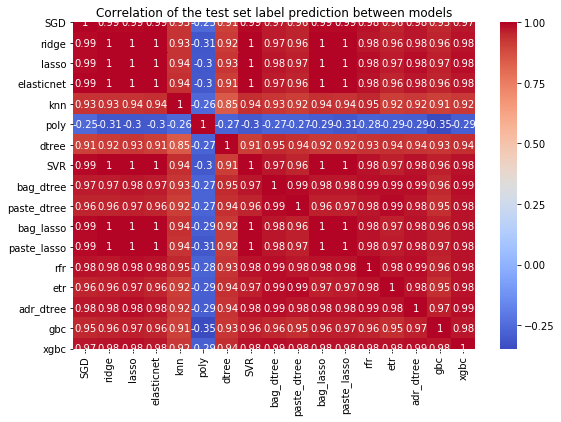

In [79]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [80]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [81]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Top Absolute Correlations
SGD   poly           0.254128
knn   poly           0.259896
poly  bag_dtree      0.268966
      dtree          0.269478
      paste_dtree    0.269865
dtype: float64


# Voting Regressor with top 5 model

In [48]:
from sklearn.ensemble import VotingRegressor

In [82]:
vclf1 = VotingRegressor(estimators=
                              [('xgbc', xgbc_grid.best_estimator_), 
                               ('SVR', grid_svr.best_estimator_), 
                               ('lasso', grid_lasso.best_estimator_),
                               ('paste_lasso', paste_lasso_grid.best_estimator_),
                               ('bag_lasso', bag_lasso_grid.best_estimator_)
                              ],  )

vclf1.fit(X_train,y_train)
vclf1_cv = cross_val_score(vclf1, X_train, y_train,cv=3)

In [83]:
print(f'Best Mean Cross Validation Score is {vclf1_cv.mean()}')

print(f'Train score is {vclf1.score(X_train,y_train)}')
print(f'Test score is {vclf1.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9009648953951759
Train score is 0.9462678716013416
Test score is 0.8923822317453297


In [86]:
X_train_preds = vclf1.predict(X_train)
X_test_preds = vclf1.predict(X_test)

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
print()

train mse: 335494376.0918758
train rmse: 18316.505564432202
train r2: 0.9462678716013416

test mse: 739561710.3380593
test rmse: 27194.883900065823
test r2: 0.8923822317453297



# Voting Regressor with least  correlated

In [84]:
vclf3 = VotingRegressor(estimators=
                              [('dtree', grid_dtree.best_estimator_), 
                               ('SGD', grid_sgd.best_estimator_), 
                               ('knn', grid_knn.best_estimator_),
                              ], )


vclf3.fit(X_train,y_train)
vclf3_cv = cross_val_score(vclf3, X_train, y_train,cv=3)

In [85]:
print(f'Best Mean Cross Validation Score is {vclf3_cv.mean()}')

print(f'Train score is {vclf3.score(X_train,y_train)}')
print(f'Test score is {vclf3.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8617610577640494
Train score is 0.920145391231533
Test score is 0.8677156773282679


# StackingRegressor with top 5 model

In [2]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\tharu\anaconda3\lib\site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


In [53]:
from sklearn.ensemble import StackingRegressor

In [58]:
sclf1 = StackingRegressor(estimators=
                               [('xgbc', xgbc_grid.best_estimator_), 
                               ('SVR', grid_svr.best_estimator_), 
                               ('lasso', grid_lasso.best_estimator_),
                               ('paste_lasso', paste_lasso_grid.best_estimator_),
                               ('bag_lasso', bag_lasso_grid.best_estimator_)
                              ], 
                                  
                           final_estimator=
                           XGBRegressor(random_state=42,objective= 'reg:squarederror'))
sclf1_param = {
              'final_estimator__max_depth' : [2,6],
              'final_estimator__n_estimators' : [50,150],
              'final_estimator__learning_rate' : [0.1,0.2,0.6],
             }


sclf1_grid = GridSearchCV(sclf1, sclf1_param,cv=5, return_train_score=True, )
sclf1_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('xgbc',
                                                      XGBRegressor(base_score=0.5,
                                                                   booster=None,
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   gpu_id=-1,
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1

In [59]:
print(f'Best Mean Cross Validation Score is {sclf1_grid.best_score_}')
print(f'Best Parameters are {sclf1_grid.best_params_}')
print(f'Train score is {sclf1_grid.score(X_train,y_train)}')
print(f'Test score is {sclf1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8899654896029064
Best Parameters are {'final_estimator__learning_rate': 0.1, 'final_estimator__max_depth': 2, 'final_estimator__min_child_weight': 1, 'final_estimator__n_estimators': 50, 'final_estimator__subsample': 0.9}
Train score is 0.9580369215006383
Test score is 0.8805803384022748


# StackingRegressor with least correlated

In [60]:
from  xgboost import XGBRegressor
sclf2 = StackingRegressor(estimators=
                               [('dtree', grid_dtree.best_estimator_), 
                               ('SGD', grid_sgd.best_estimator_), 
                               ('knn', grid_knn.best_estimator_),
                              ] , 
                           final_estimator=
                           XGBRegressor(random_state=42,objective= 'reg:squarederror'))
sclf2_param = {
              'final_estimator__max_depth' : [2,6],
              'final_estimator__n_estimators' : [50,150],
              'final_estimator__learning_rate' : [0.1,0.2,0.6],
              'final_estimator__min_child_weight' : [1,3,7],
              'final_estimator__subsample':[0.6,0.9,1],
             }
sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=5, return_train_score=True, )
sclf2_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=None,
                                         estimators=[('dtree',
                                                      DecisionTreeRegressor(ccp_alpha=0.0,
                                                                            criterion='mse',
                                                                            max_depth=6,
                                                                            max_features=None,
                                                                            max_leaf_nodes=None,
                                                                            min_impurity_decrease=0.0,
                                                                            min_impurity_split=None,
                                                                            min_samples_leaf=1,
                                                                            min_sample

In [61]:
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8855268912193932
Best Mean Cross Validation Score is {'final_estimator__learning_rate': 0.1, 'final_estimator__max_depth': 2, 'final_estimator__min_child_weight': 1, 'final_estimator__n_estimators': 50, 'final_estimator__subsample': 0.6}
Train score is 0.9079308327940276
Test score is 0.8957860319418709
